# Hill Climber Class

|   | Hill Climbing Algorithm | Neighbor Generation                       | Number of Neighbors    | Termination                                   | Exploration vs. Exploitation |
|---|-------------------------|-------------------------------------------|------------------------|-----------------------------------------------|------------------------------|
| V | First-choice            | Random neighbor, stops when better found  | 1 until better found   | No improvement for a set number of iterations | Mostly exploitation          |
| V | Steepest Ascent         | All possible neighbors, best selected     | All possible neighbors | No better neighbor found                      | Pure exploitation            |
|   | Gradient Descent        | Next point based on gradient              | 1                      | No improvement in next step                   | Pure exploitation            |
|   | Stochastic              | Multiple neighbors, chosen stochastically | Multiple               | No improvement for a set number of iterations | Mostly exploitation          |
|   | Simulated Annealing     | Random neighbor                           | 1                      | Temperature reaches zero or eval limit        | Balanced                     |



<img src="https://www.researchgate.net/profile/John-Hogden/publication/291419889/figure/fig2/AS:320895026515974@1453518744135/Schematic-showing-the-trade-off-between-exploration-and-exploitation-A-hypothetical.png" width=400>

> Schematic showing the trade-off between **exploration** and **exploitation**.: A hypothetical fitness landscape (shown as continuous red line) from the regression model in an abstract high-dimensional feature space with two local maxima. One of the maxima has a data point with a relatively large value for mean, but small uncertainty (error bar). This is due to its close proximity to the best material that is known so far in the training set (blue circle), where the regression algorithm has trained well. The other local maximum, in contrast, has a data point with small mean value (red circle), but relatively large uncertainty.

Prasanna V. Balachandran et. al., Adaptive Strategies for Materials Design using Uncertainties (2016)

 # Scikit-learn Convention

The Scikit-learn convention typically follows a certain approach, but in our classes, we frequently encounter problems that require finding the minimum value of a cost or objective function. Therefore, **our implementation adopts a method that is contrary to the standard Scikit-learn convention**.

 https://scikit-learn.org/stable/modules/model_evaluation.html

 > All scorer objects follow **the convention that higher return values are better than lower return values**. Thus metrics which measure the distance between the model and the data, like metrics.mean_squared_error, are available as neg_mean_squared_error which return the negated value of the metric.


In [2]:
class HillClimber:
  def __init__(self, generate_neighbor,
                objective_function,
                initial_solution_generator,
                step_size=0.1,
                num_neighbors=1,
                max_iter=1000,
                num_restarts=10,
                ):
    self.generate_neighbor = generate_neighbor
    self.objective_function = objective_function
    self.initial_solution_generator = initial_solution_generator
    self.step_size = step_size
    self.num_neighbors = num_neighbors
    self.max_iter = max_iter
    self.num_restarts = num_restarts
    self.best_solution = None
    self.best_score = float('inf')

  def fit(self):
    self.current_solution = self.initial_solution_generator()
    for _ in range(self.max_iter):
      neighbors = self.generate_neighbor(solution=self.current_solution, step_size=self.step_size, num_neighbors=self.num_neighbors)
      neighbors_scores = [self.objective_function(neighbor) for neighbor in neighbors]
      best_neighbor_index = np.argmin(neighbors_scores)
      best_neighbor = neighbors[best_neighbor_index]

      if neighbors_scores[best_neighbor_index] < self.best_score:
        self.best_solution = best_neighbor
        self.best_score = neighbors_scores[best_neighbor_index]
        self.current_solution = best_neighbor

    return self.best_solution

  def predict(self):
    return self.best_solution

  def score(self):
    return self.best_score

  def random_restart(self):
    for _ in range(self.num_restarts):
      self.fit()
      new_solution = self.predict()
      new_score = self.score()

      if new_score < self.best_score:
        self.best_solution = new_solution
        self.best_score = new_score

# 5. SimulatedAnnealingHillClimber

## Acceptance Probability

* Determine whether to move to the neighbor solution or stay with the current solution. This is where the temperature comes into play.

* If the neighbor solution is better, it is always accepted.

* If it is worse, it may still be accepted with a probability

$$ \alpha e^{-\frac{𝚫E}{T}} $$

where:

* α is The normalizing factor. We have treated
 α as 1

* 𝚫E is the increase in energy (cost). In the our class, cost difference is next.SCORE − current.SCORE

* T is the current temperature.

## Cooling Schedule

| FAST                | SLOW     |
|---------------------|----------|
| <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/82/SimulatedAnnealingFast.jpg/384px-SimulatedAnnealingFast.jpg"> | <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/8d/SimulatedAnnealingSlow.jpg/384px-SimulatedAnnealingSlow.jpg" > |

> Example illustrating the effect of cooling schedule on the performance of simulated annealing. The problem is to rearrange the pixels of an image so as to minimize a certain potential energy function, which causes similar colors to attract at short range and repel at a slightly larger distance. The elementary moves swap two adjacent pixels. These images were obtained with a fast cooling schedule (left) and a slow cooling schedule (right), producing results similar to amorphous and crystalline solids, respectively.

ref. https://en.wikipedia.org/wiki/Simulated_annealing

## Pseudocode

```
Let s = s0
For k = 0 through kmax (exclusive):
    T ← temperature( 1 - (k+1)/kmax )
    Pick a random neighbour, snew ← neighbour(s)
    If P(E(s), E(snew), T) ≥ random(0, 1):
      s ← snew
Output: the final state s
```

* The following pseudocode presents the simulated annealing heuristic as described above.
* It **starts from a state s0** and continues until a maximum of kmax steps have been taken.
* In the process, the call **neighbour(s)** should generate a **randomly chosen neighbour** of a given state s;
* The call **random(0, 1)** should pick and return a value in **the range [0, 1], uniformly at random**.
* The annealing schedule is defined by the call **temperature(r)**, which should yield the temperature to use, given the fraction r of the time budget that has been expended so far.

In [39]:
import numpy as np
import random

class SimulatedAnnealingHillClimber(HillClimber):
  def __init__(self, generate_neighbor, objective_function, initial_solution_generator, step_size=0.1, num_neighbors=1, max_iter=10000, num_restarts=10, temperature=1.0, alpha=1.0):
    super().__init__(generate_neighbor, objective_function, initial_solution_generator, step_size, num_neighbors, max_iter, num_restarts)
    self.temperature = temperature
    self.alpha = alpha

  def _acceptance_probability(self, cur_cost, new_cost):
    # self.alpha * pow((new_cost - cur_cost), 
    return np.exp(-(new_cost - cur_cost) / (self.temperature + 1e-2))
    pass

  def _cooling_schedule(self, k):
    self.temperature *= (1.0 - ((k + 1.0) / self.max_iter))
    pass

  def fit(self):
    self.current_solution = self.initial_solution_generator()
    for k in range(self.max_iter):
      self._cooling_schedule(k)
      neighbors = self.generate_neighbor(solution=self.current_solution, step_size=self.step_size, num_neighbors=self.num_neighbors)
      neighbors_scores = [self.objective_function(neighbor) for neighbor in neighbors]
      best_neighbor_index = np.argmin(neighbors_scores)
      best_neighbor = neighbors[best_neighbor_index]

      if neighbors_scores[best_neighbor_index] < self.best_score:
        self.best_solution = best_neighbor
        self.best_score = neighbors_scores[best_neighbor_index]
        self.current_solution = best_neighbor
      elif self._acceptance_probability(self.best_score, neighbors_scores[best_neighbor_index]) >= random.uniform(0, 1):
        neighbors = self.generate_neighbor(solution=self.current_solution, step_size=self.step_size, num_neighbors=self.num_neighbors)
        neighbors_scores = [self.objective_function(neighbor) for neighbor in neighbors]
        best_neighbor_index = np.argmin(neighbors_scores)
        best_neighbor = neighbors[best_neighbor_index]

    return self.best_solution


In [42]:
from functools import partial
import numpy as np

def objective_function(x):
    return (x[0] - 2) ** 2 + 5 * (x[1] - 5) ** 2 + 8 * (x[2] + 8) ** 2 + 3 * (x[3] + 1) ** 2 + 6 * (x[4] - 7) ** 2


def continuous_generate_neighbor(solution, step_size, num_neighbors):
    neighbors = []
    for _ in range(num_neighbors):
        neighbors.append(solution + np.random.uniform(-step_size, step_size, len(solution)))
    return neighbors


def initial_solution_generator(n=5):
    return [np.random.uniform(-30, 30) for _ in range(n)]


# Test the GradientDescentHillClimber class
hill_climber = SimulatedAnnealingHillClimber(
    generate_neighbor=continuous_generate_neighbor,
    objective_function=objective_function,
    initial_solution_generator=initial_solution_generator,
)

hill_climber.fit()

print(f"Gradient Descent Hill Climber Best Solution: {hill_climber.predict()}")
print(f"Gradient Descent Hill Climber Best Score: {hill_climber.score():.5f}")

Gradient Descent Hill Climber Best Solution: [ 2.02840718  4.98365049 -8.00104042 -1.01552293  7.01097428]
Gradient Descent Hill Climber Best Score: 0.00360


In [ ]:

import numpy as np
import random
import math

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Define the TSP environment
cities = [
    (8, 31), (54, 97), (50, 50), (65, 16), (70, 47), (25, 100), (55, 74), (77, 87),
    (6, 46), (70, 78), (13, 38), (100, 32), (26, 35), (55, 16), (26, 77), (17, 67),
    (40, 36), (38, 27), (33, 2), (48, 9), (62, 20), (17, 92), (30, 2), (80, 75),
    (32, 36), (43, 79), (57, 49), (18, 24), (96, 76), (81, 39)
]



152
683.0021059542663


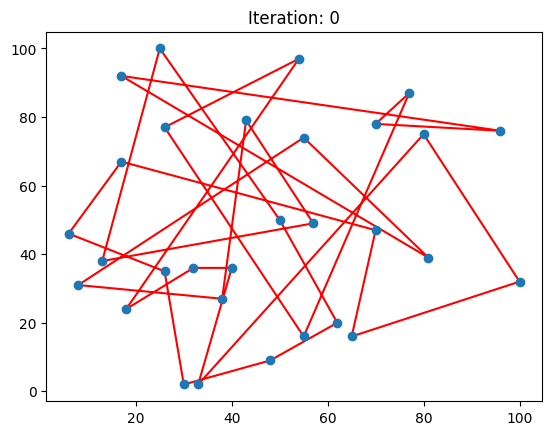

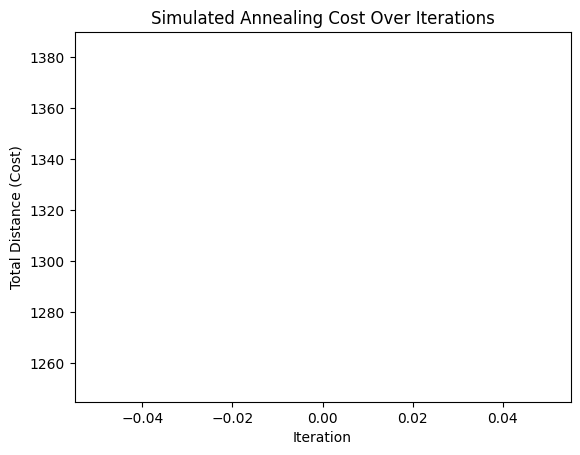

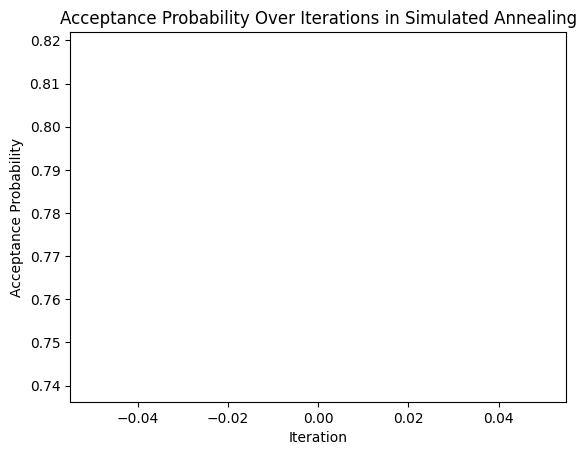

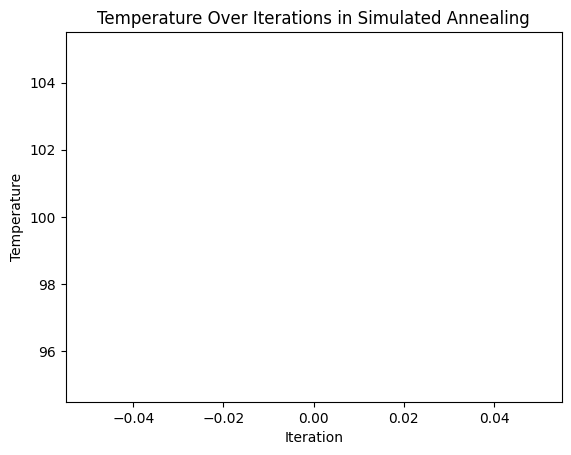

# 1. FirstChoiceHillClimber

Given the base class HillClimber, implement a FirstChoiceHillClimber class that extends the functionality of hill climbing by selecting the first neighboring solution that is better than the current solution. Override the fit method to perform the hill climbing process, predict to return the best solution found, and score to return the objective value of the best solution.

In [ ]:
class FirstChoiceHillClimber(HillClimber):
    pass

#2. SteepestAscentHillClimber


Using the provided HillClimber class, create a SteepestAscentHillClimber class that finds the best neighbor out of all possible neighbor solutions generated in one iteration and moves to it if it is better than the current solution. Implement fit, predict, and score methods according to the class' operations.

In [ ]:
class SteepestAscentHillClimber(HillClimber):
  def fit(self):
    pass

#3. GradientDescentHillClimber

GradientDescentHillClimber class using the convex_function as the objective function. We will test these classes to see if they can minimize this function, starting from a random initial solution in a 5-dimensional space.

```
def convex_function(x):
    return (x[0] - 2) ** 2 + 5 * (x[1] - 5) ** 2 + 8 * (x[2] + 8) ** 2 + 3 * (x[3] + 1) ** 2 + 6 * (x[4] - 7) ** 2
```

In [ ]:
class GradientDescentHillClimber(HillClimber):
    def __init__(self, gradient_function, objective_function, initial_solution_generator, step_size=0.1, num_neighbors=1, learning_rate=0.01, max_iter=1000, mode='min', num_restarts=10):
      super().__init__(gradient_function, objective_function, initial_solution_generator, step_size, num_neighbors, max_iter, mode, num_restarts)
      self.learning_rate = learning_rate

# 4. RandomRestartHillClimber ??

Random Restart is a strategy used to overcome the limitations of local search algorithms, which might get stuck in local optima. The idea is to run a local search algorithm repeatedly from different random starting points.

> Compared to these algorithms (FirstChoice, Steepest, GradientDescent), the random restart mechanism is actually a different approach.

```
for _ in range(num_restarts):
  algorithm.fit()
  new_solution = algorithm.predict()
  new_score = algorithm.score()
  if (is_better(best_score, new_score):
    best_solution = new_solution
    best_score = new_score
```

In [ ]:
# xxxx.random_restart()

# Evaluation Functions



| Ackley | Griewank | Convex |
|------|----------|-----|
| <img src="https://drive.google.com/uc?id=1M1slit0Toi9fSt5A_XFPLHdC73vue9-_" width="400"/>   | <img src="https://drive.google.com/uc?id=1dz2iCffrUXVa7bB4ohxjvDXPp3ud0vTO" width="400"/>      |   <img src="https://drive.google.com/uc?id=1FRXc3t5WQlKRWHT_sj7xfhocITK3-RoW" width="400"/>  |

```
def ackley_function(x):
    term1 = -20 * math.exp(-0.2 * math.sqrt(sum(xi ** 2 for xi in x) / len(x)))
    term2 = -math.exp(sum(math.cos(2 * math.pi * xi) for xi in x) / len(x))
    return 20 + math.e + term1 + term2

def convex_function(x):
    return (x[0] - 2) ** 2 + 5 * (x[1] - 5) ** 2 + 8 * (x[2] + 8) ** 2 + 3 * (x[3] + 1) ** 2 + 6 * (x[4] - 7) ** 2

def griewank_function(x):
    sum_term = sum(xi ** 2 for xi in x) / 4000
    prod_term = math.cos(x[0])
    for i, xi in enumerate(x[1:], start=2):
        prod_term *= math.cos(xi / math.sqrt(i))
    return 1 + sum_term - prod_term
```



# 0. Discrete Problem Test

In [ ]:
cities = [
    (8, 31), (54, 97), (50, 50), (65, 16), (70, 47), (25, 100), (55, 74), (77, 87),
    (6, 46), (70, 78), (13, 38), (100, 32), (26, 35), (55, 16), (26, 77), (17, 67),
    (40, 36), (38, 27), (33, 2), (48, 9), (62, 20), (17, 92), (30, 2), (80, 75),
    (32, 36), (43, 79), (57, 49), (18, 24), (96, 76), (81, 39)
]


# Version History

VERSION 0.4:
* Removed learning_rate as it's more specific to gradient descent. Streamlined other parameters.
* Aligning with the common practice in optimization of minimizing a cost or objective function.
* Simplified the neighbor evaluation process. Directly uses np.argmin for finding the best neighbor, assuming minimization problems.


VERSION 0.3:
* Removed current_solution initialization from the constructor.
* Added num_neighbor to control the number of neighbors generated per iteration.
* Added best_score_idx, a lambda function to find the index of the best score from a list of scores. This is used when evaluating multiple neighbors.
* The current solution is now initialized at the start of the fit method.
* Generates multiple neighbors (num_neighbor) per iteration and evaluates them.
* Selects the best neighbor based on the scores and updates the current and best solutions if necessary.
* Implements the random restart mechanism. It calls fit method multiple times (num_restarts) and keeps track of the overall best solution.


VERSION 0.2:
* Introduced the mode parameter to toggle between maximization and minimization.
* Added a lambda function, is_better, to abstract the comparison logic based on the mode.
* The best_score is now set based on the mode of operation.
* The fit method is updated to use the is_better function for comparison.



VERSION 0.1:
* Basic hill climbing functionality to maximize an objective function.
* The fit method only seeks to improve (maximize) the objective function score.
* The best_score is initialized to negative infinity to ensure any score is better.
